In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.num_class = num_class

    def forward(self, x):
        x[x == 255] = 21
        return F.one_hot(x.to(torch.int64), self.num_class).permute(0, 3, 1, 2)[0].float()

transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.PILToTensor(), 
        MakeClass(22)
    ]
)

train_ds = VOCSegmentation(
    root = "~/data", image_set = "train", download = True, year = "2008",
    transform = transform, 
    target_transform = target_transform
)

valid_ds = VOCSegmentation(
    root = "~/data", image_set = "trainval", download = True, year = "2008",
    transform = transform, 
    target_transform = target_transform    
)

test_ds = VOCSegmentation(
    root = "~/data", image_set = "val", download = True, year = "2008",
    transform = transform, 
    target_transform = target_transform
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Validation Samples: {}".format(len(valid_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Validation Batch: {}".format(len(valid_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

100%|█████████████████████████████████████████████████████| 577034240/577034240 [10:46<00:00, 892909.55it/s]


Extracting /home/khoidh/data/VOCtrainval_11-May-2012.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_11-May-2012.tar
Extracting /home/khoidh/data/VOCtrainval_11-May-2012.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_11-May-2012.tar
Extracting /home/khoidh/data/VOCtrainval_11-May-2012.tar to /home/khoidh/data
#Training Samples: 511
#Validation Samples: 1023
#Testing Samples: 512
#Training Batch: 16
#Validation Batch: 32
#Testing Batch: 16


Total #Class: 22
data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([22, 256, 256])
Number classes: 22
Classes: tensor([ 0, 15, 21])


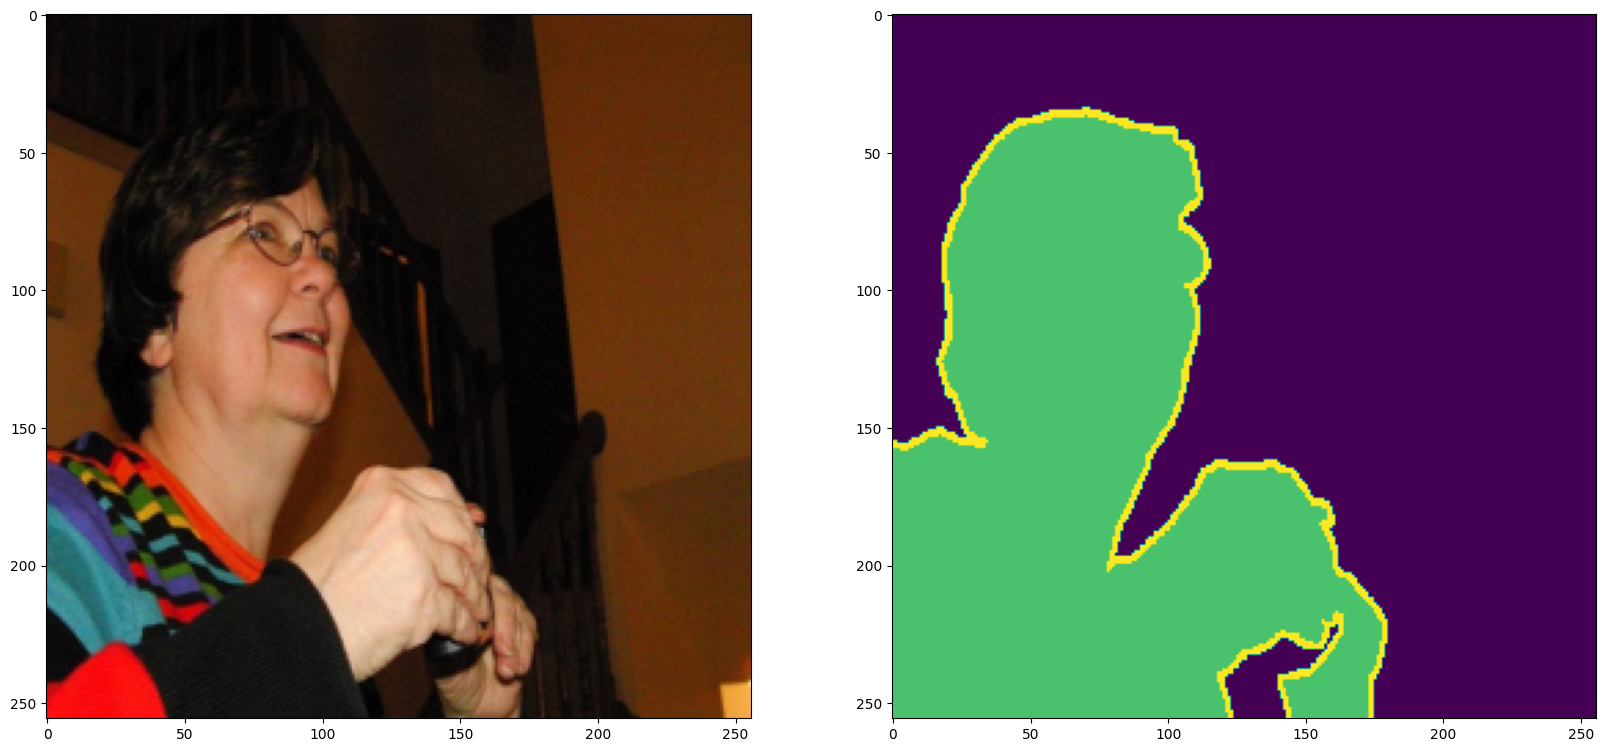

In [3]:
sample_data, sample_mask = train_ds[200]
total_num_class = 22

print(f"Total #Class: {total_num_class}")
print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")
num_class = sample_mask.shape[0]
print(f"Number classes: {num_class}")
print(f"Classes: {torch.unique(torch.argmax(sample_mask, dim = 0))}")

f, axarr = plt.subplots(1, 2, figsize=(20, 15))
axarr[0].imshow(sample_data.permute(1, -1, 0).numpy())
axarr[1].imshow(torch.argmax(sample_mask, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [5]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [6]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [7]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, total_num_class, True).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [11]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.cpu().item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device)
            
            valid_gen_mask = model(valid_img)
            valid_rec_loss = loss_fn(valid_gen_mask, valid_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                valid_mask.float(),
                multiclass=True
            )
            valid_loss = valid_rec_loss + valid_dice_loss

            va_total_loss += valid_loss.cpu().item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(valid_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.17it/s]


Epoch: 0 - TrainLoss: 3.4963187128305435 - ValidLoss: 36.20978033542633


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.24it/s]


Epoch: 1 - TrainLoss: 3.0561762750148773 - ValidLoss: 2.8173977360129356


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.36it/s]


Epoch: 2 - TrainLoss: 2.7229991406202316 - ValidLoss: 2.883927568793297


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.58it/s]


Epoch: 3 - TrainLoss: 2.4510802030563354 - ValidLoss: 2.473788969218731


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.49it/s]


Epoch: 4 - TrainLoss: 2.214722156524658 - ValidLoss: 2.2337393015623093


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.53it/s]


Epoch: 5 - TrainLoss: 2.0329564064741135 - ValidLoss: 2.4829214587807655


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.11it/s]


Epoch: 6 - TrainLoss: 1.8899079263210297 - ValidLoss: 1.9125805422663689


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.44it/s]


Epoch: 7 - TrainLoss: 1.8078678175807 - ValidLoss: 1.880993451923132


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.44it/s]


Epoch: 8 - TrainLoss: 1.7435269206762314 - ValidLoss: 1.8049530014395714


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.35it/s]


Epoch: 9 - TrainLoss: 1.7244733050465584 - ValidLoss: 1.784450400620699


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.50it/s]


Epoch: 10 - TrainLoss: 1.6891206726431847 - ValidLoss: 1.7477018237113953


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.43it/s]


Epoch: 11 - TrainLoss: 1.6660749912261963 - ValidLoss: 1.6888889782130718


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.42it/s]


Epoch: 12 - TrainLoss: 1.6481918916106224 - ValidLoss: 1.72682548686862


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.47it/s]


Epoch: 13 - TrainLoss: 1.6381356343626976 - ValidLoss: 1.6699326746165752


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.43it/s]


Epoch: 14 - TrainLoss: 1.6160782128572464 - ValidLoss: 1.6497939303517342


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.35it/s]


Epoch: 15 - TrainLoss: 1.6169297695159912 - ValidLoss: 1.6567050106823444


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.42it/s]


Epoch: 16 - TrainLoss: 1.601003758609295 - ValidLoss: 1.6829047873616219


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.42it/s]


Epoch: 17 - TrainLoss: 1.590878039598465 - ValidLoss: 1.614013161510229


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.50it/s]


Epoch: 18 - TrainLoss: 1.590179555118084 - ValidLoss: 1.6484000720083714


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.32it/s]


Epoch: 19 - TrainLoss: 1.584690123796463 - ValidLoss: 1.6673935018479824


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.41it/s]


Epoch: 20 - TrainLoss: 1.5555440858006477 - ValidLoss: 1.6026012636721134


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.39it/s]


Epoch: 21 - TrainLoss: 1.552650809288025 - ValidLoss: 1.6000301018357277


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.26it/s]


Epoch: 22 - TrainLoss: 1.546572633087635 - ValidLoss: 1.5823549665510654


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.48it/s]


Epoch: 23 - TrainLoss: 1.5304746553301811 - ValidLoss: 1.6263061836361885


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.56it/s]


Epoch: 24 - TrainLoss: 1.5112114399671555 - ValidLoss: 1.5936970002949238


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.42it/s]


Epoch: 25 - TrainLoss: 1.5119317695498466 - ValidLoss: 1.5649823732674122


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.44it/s]


Epoch: 26 - TrainLoss: 1.490055575966835 - ValidLoss: 1.5530634224414825


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.36it/s]


Epoch: 27 - TrainLoss: 1.4703440219163895 - ValidLoss: 1.601570751518011


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.43it/s]


Epoch: 28 - TrainLoss: 1.4616406336426735 - ValidLoss: 1.5311768054962158


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.40it/s]


Epoch: 29 - TrainLoss: 1.4523651450872421 - ValidLoss: 1.549616500735283


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.58it/s]


Epoch: 30 - TrainLoss: 1.4422526210546494 - ValidLoss: 1.491418331861496


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.48it/s]


Epoch: 31 - TrainLoss: 1.419714093208313 - ValidLoss: 1.5646453946828842


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.34it/s]


Epoch: 32 - TrainLoss: 1.4243298843502998 - ValidLoss: 1.6748215220868587


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.34it/s]


Epoch: 33 - TrainLoss: 1.419326402246952 - ValidLoss: 1.5811097547411919


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.37it/s]


Epoch: 34 - TrainLoss: 1.4008995443582535 - ValidLoss: 1.4628852009773254


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.71it/s]


Epoch: 35 - TrainLoss: 1.365563876926899 - ValidLoss: 1.4930959939956665


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.43it/s]


Epoch: 36 - TrainLoss: 1.3765057101845741 - ValidLoss: 1.4622746780514717


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.45it/s]


Epoch: 37 - TrainLoss: 1.3650695458054543 - ValidLoss: 1.4708971045911312


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.19it/s]


Epoch: 38 - TrainLoss: 1.351549968123436 - ValidLoss: 1.4288061261177063


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.33it/s]


Epoch: 39 - TrainLoss: 1.3353624939918518 - ValidLoss: 1.5382179208099842


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.26it/s]


Epoch: 40 - TrainLoss: 1.3300561159849167 - ValidLoss: 1.4299915954470634


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.37it/s]


Epoch: 41 - TrainLoss: 1.310860700905323 - ValidLoss: 1.4174626283347607


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.50it/s]


Epoch: 42 - TrainLoss: 1.2905318439006805 - ValidLoss: 1.4266373254358768


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.43it/s]


Epoch: 43 - TrainLoss: 1.2782318741083145 - ValidLoss: 1.4511887431144714


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.43it/s]


Epoch: 44 - TrainLoss: 1.2670145258307457 - ValidLoss: 1.3986013233661652


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.23it/s]


Epoch: 45 - TrainLoss: 1.2657359689474106 - ValidLoss: 1.4483818262815475


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.41it/s]


Epoch: 46 - TrainLoss: 1.245046079158783 - ValidLoss: 1.3878581747412682


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.48it/s]


Epoch: 47 - TrainLoss: 1.2263953387737274 - ValidLoss: 1.5385321527719498


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.44it/s]


Epoch: 48 - TrainLoss: 1.2046633809804916 - ValidLoss: 1.45144684612751


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.38it/s]


Epoch: 49 - TrainLoss: 1.2040091045200825 - ValidLoss: 1.3953814171254635


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.37it/s]


Epoch: 50 - TrainLoss: 1.183385033160448 - ValidLoss: 1.4565535485744476


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.38it/s]


Epoch: 51 - TrainLoss: 1.1770425587892532 - ValidLoss: 1.3702044673264027


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.58it/s]


Epoch: 52 - TrainLoss: 1.157161608338356 - ValidLoss: 1.3559208996593952


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.42it/s]


Epoch: 53 - TrainLoss: 1.133070807904005 - ValidLoss: 1.3988382667303085


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.31it/s]


Epoch: 54 - TrainLoss: 1.1192018762230873 - ValidLoss: 1.3743188865482807


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.31it/s]


Epoch: 55 - TrainLoss: 1.0976767465472221 - ValidLoss: 1.324264757335186


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.39it/s]


Epoch: 56 - TrainLoss: 1.0954609476029873 - ValidLoss: 1.3461148776113987


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.43it/s]


Epoch: 57 - TrainLoss: 1.0594957955181599 - ValidLoss: 1.3338309451937675


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.46it/s]


Epoch: 58 - TrainLoss: 1.0593409165740013 - ValidLoss: 1.3510181792080402


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.43it/s]


Epoch: 59 - TrainLoss: 1.0501348078250885 - ValidLoss: 1.3286457173526287


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.17it/s]


Epoch: 60 - TrainLoss: 1.0338334329426289 - ValidLoss: 1.3234226442873478


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.34it/s]


Epoch: 61 - TrainLoss: 1.018321469426155 - ValidLoss: 1.2937614619731903


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.41it/s]


Epoch: 62 - TrainLoss: 0.9927444793283939 - ValidLoss: 1.3496436569839716


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.31it/s]


Epoch: 63 - TrainLoss: 0.9648998938500881 - ValidLoss: 1.2613276466727257


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.35it/s]


Epoch: 64 - TrainLoss: 0.9525060467422009 - ValidLoss: 1.3052871841937304


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.39it/s]


Epoch: 65 - TrainLoss: 0.9502507522702217 - ValidLoss: 1.2666386924684048


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.31it/s]


Epoch: 66 - TrainLoss: 0.9568832665681839 - ValidLoss: 1.2665478829294443


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.44it/s]


Epoch: 67 - TrainLoss: 0.9215927757322788 - ValidLoss: 1.2528065517544746


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.44it/s]


Epoch: 68 - TrainLoss: 0.9055405296385288 - ValidLoss: 1.299070941284299


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.38it/s]


Epoch: 69 - TrainLoss: 0.8997023403644562 - ValidLoss: 1.2923861555755138


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.21it/s]


Epoch: 70 - TrainLoss: 0.8849801532924175 - ValidLoss: 1.2534808814525604


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.43it/s]


Epoch: 71 - TrainLoss: 0.8751170448958874 - ValidLoss: 1.253018220886588


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.49it/s]


Epoch: 72 - TrainLoss: 0.8730508647859097 - ValidLoss: 1.231012487784028


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.39it/s]


Epoch: 73 - TrainLoss: 0.861129280179739 - ValidLoss: 1.2177073024213314


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.37it/s]


Epoch: 74 - TrainLoss: 0.8346669152379036 - ValidLoss: 1.2201116923242807


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.34it/s]


Epoch: 75 - TrainLoss: 0.8319860585033894 - ValidLoss: 1.2176036220043898


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.37it/s]


Epoch: 76 - TrainLoss: 0.8192035630345345 - ValidLoss: 1.2079205680638552


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.40it/s]


Epoch: 77 - TrainLoss: 0.8095883876085281 - ValidLoss: 1.1968213934451342


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.42it/s]


Epoch: 78 - TrainLoss: 0.7996404208242893 - ValidLoss: 1.1954504530876875


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.34it/s]


Epoch: 79 - TrainLoss: 0.7761158384382725 - ValidLoss: 1.2113224919885397


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.48it/s]


Epoch: 80 - TrainLoss: 0.8013052344322205 - ValidLoss: 1.2169104889035225


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.31it/s]


Epoch: 81 - TrainLoss: 0.7786589823663235 - ValidLoss: 1.2066879533231258


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.47it/s]


Epoch: 82 - TrainLoss: 0.7641907259821892 - ValidLoss: 1.1895647048950195


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.42it/s]


Epoch: 83 - TrainLoss: 0.7677569463849068 - ValidLoss: 1.1900170110166073


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.39it/s]


Epoch: 84 - TrainLoss: 0.7710332944989204 - ValidLoss: 1.1825430393218994


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.45it/s]


Epoch: 85 - TrainLoss: 0.7727547734975815 - ValidLoss: 1.181002689525485


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.40it/s]


Epoch: 86 - TrainLoss: 0.7690658159554005 - ValidLoss: 1.1751454174518585


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.44it/s]


Epoch: 87 - TrainLoss: 0.7587689347565174 - ValidLoss: 1.1762191280722618


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.44it/s]


Epoch: 88 - TrainLoss: 0.7430355027318001 - ValidLoss: 1.16746904887259


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.32it/s]


Epoch: 89 - TrainLoss: 0.7457143738865852 - ValidLoss: 1.1725756097584963


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.30it/s]


Epoch: 90 - TrainLoss: 0.7296445332467556 - ValidLoss: 1.172872256487608


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.38it/s]


Epoch: 91 - TrainLoss: 0.725868109613657 - ValidLoss: 1.1749025136232376


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.46it/s]


Epoch: 92 - TrainLoss: 0.732201311737299 - ValidLoss: 1.1717569306492805


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.38it/s]


Epoch: 93 - TrainLoss: 0.7347184866666794 - ValidLoss: 1.1725540831685066


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.33it/s]


Epoch: 94 - TrainLoss: 0.7271933555603027 - ValidLoss: 1.1699732542037964


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.39it/s]


Epoch: 95 - TrainLoss: 0.7408691346645355 - ValidLoss: 1.1707678269594908


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.44it/s]


Epoch: 96 - TrainLoss: 0.7265558764338493 - ValidLoss: 1.1719101965427399


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.45it/s]


Epoch: 97 - TrainLoss: 0.7328872121870518 - ValidLoss: 1.1729779988527298


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.37it/s]


Epoch: 98 - TrainLoss: 0.7288061194121838 - ValidLoss: 1.1711682341992855


100%|███████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.36it/s]

Epoch: 99 - TrainLoss: 0.7434491328895092 - ValidLoss: 1.1716657411307096


<All keys matched successfully>

In [12]:
model.eval()
with torch.no_grad():
    ts_total_loss = 0
    for test_img, test_mask in tqdm(test_dl):
        test_img = test_img.to(device)
        test_mask = test_mask.to(device)
        
        test_gen_mask = model(test_img)
        test_rec_loss = loss_fn(test_gen_mask, test_mask)
        test_dice_loss = dice_loss(
            F.softmax(test_gen_mask, dim=1).float(),
            test_mask.float(),
            multiclass=True
        )
        test_loss = test_rec_loss + test_dice_loss

        ts_total_loss += test_loss.cpu().item()
mean_test_loss = ts_total_loss/len(test_dl)
print(f"TestLoss: {mean_test_loss}")

100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.86it/s]

TestLoss: 1.671599954366684


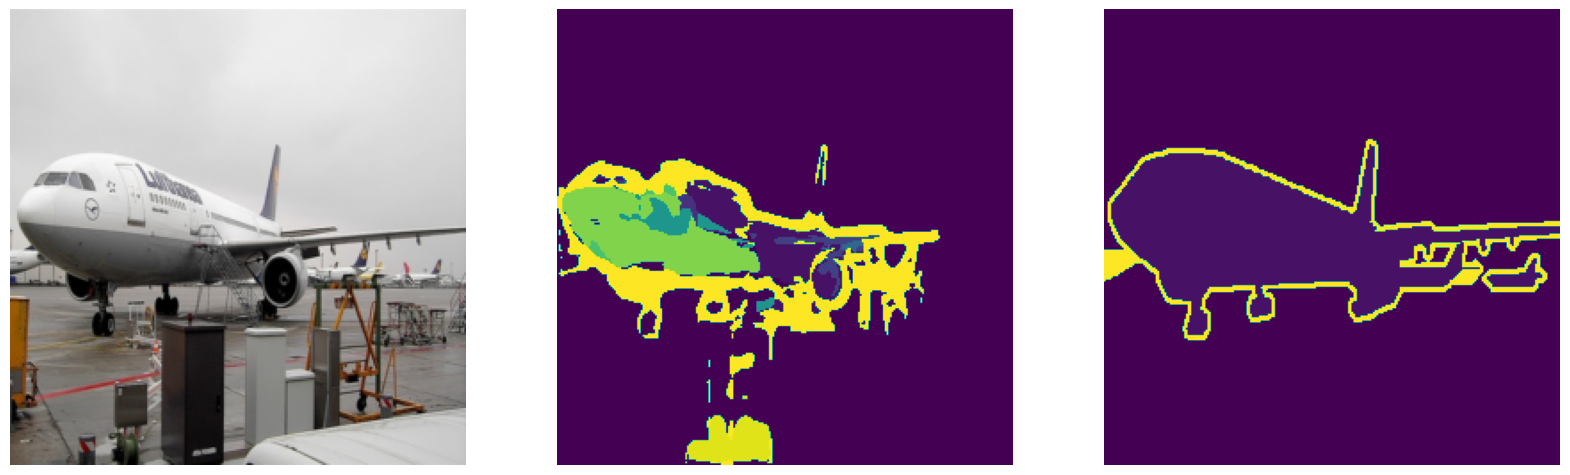

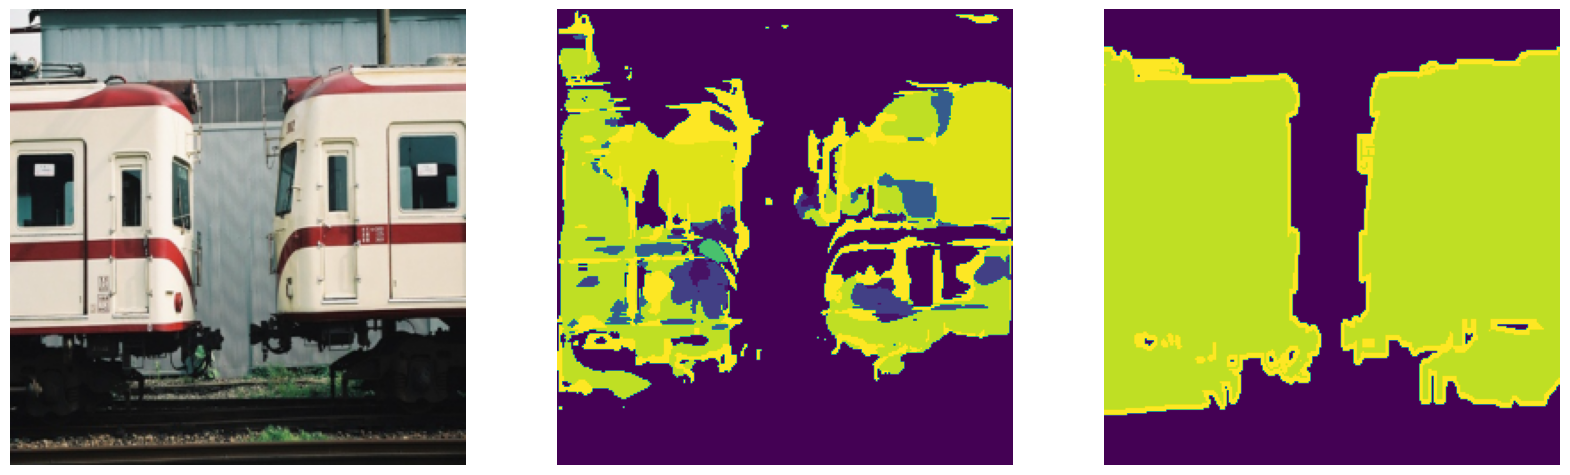

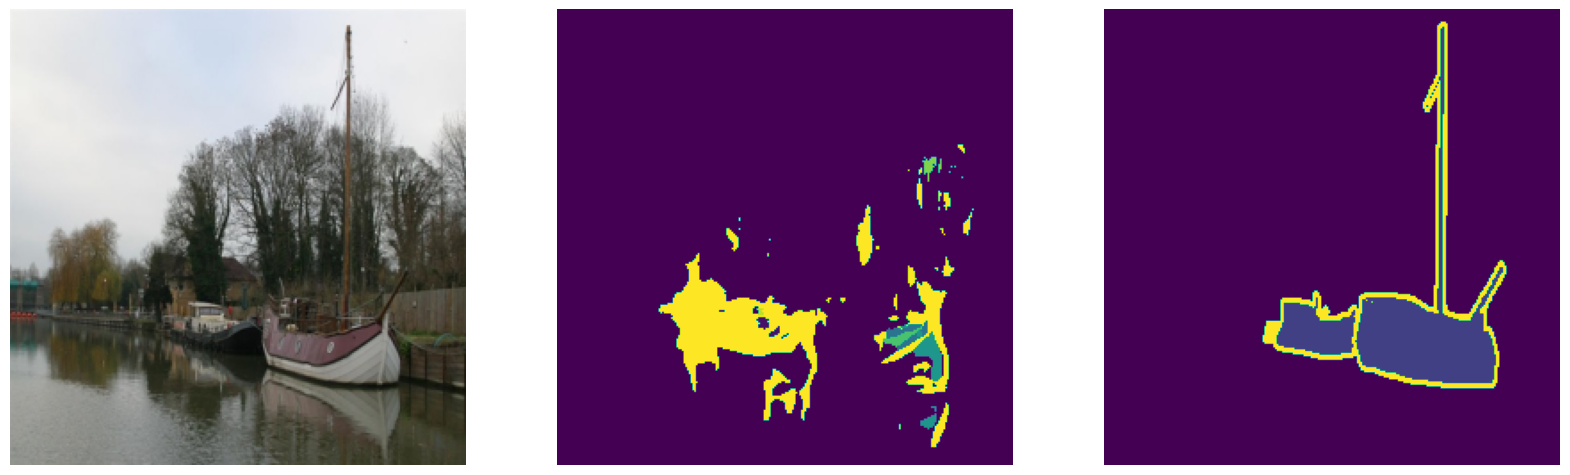

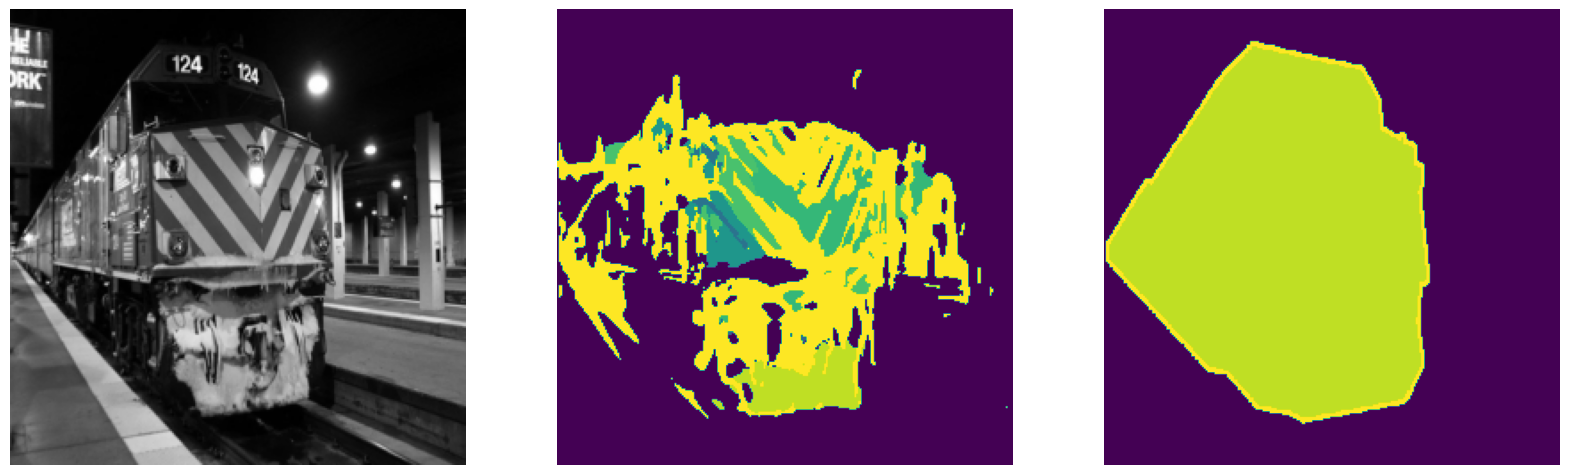

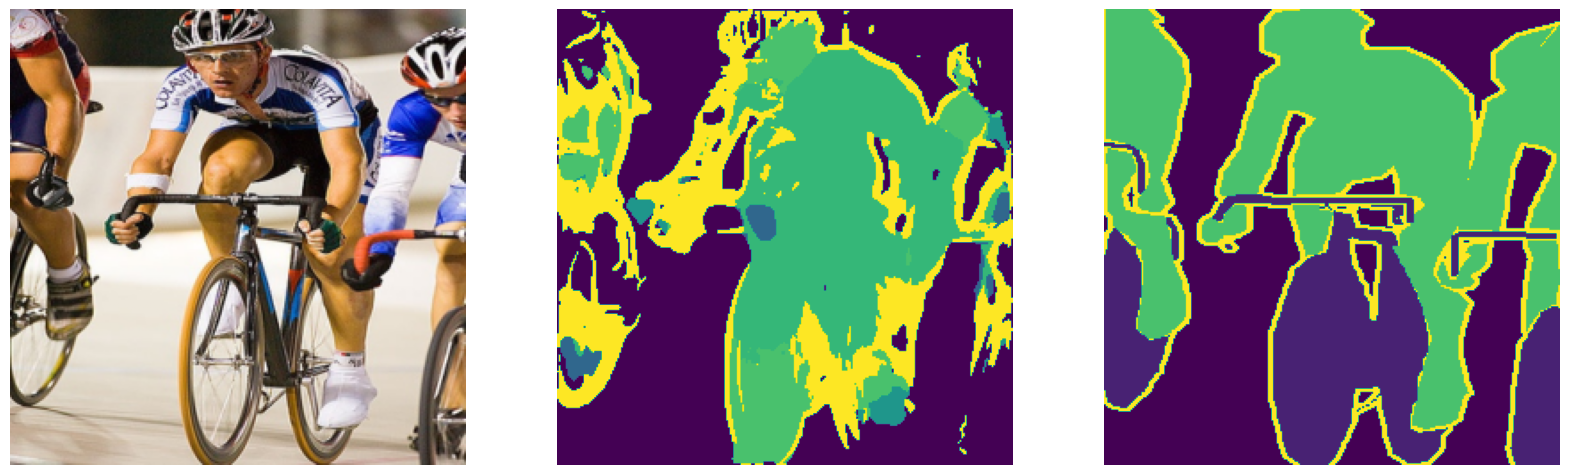

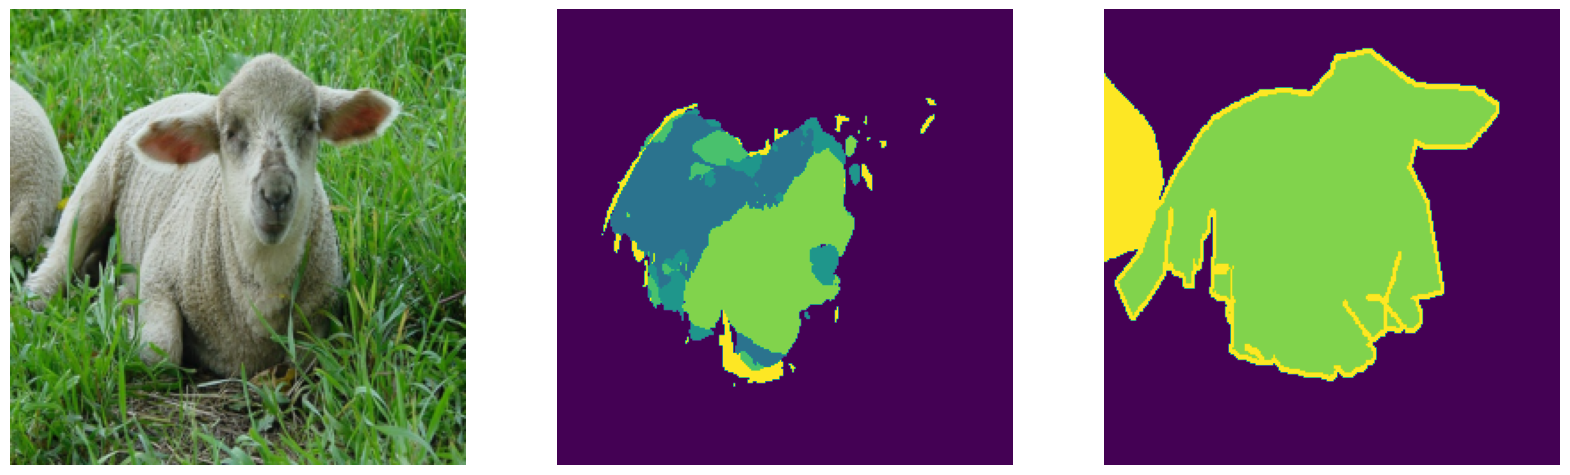

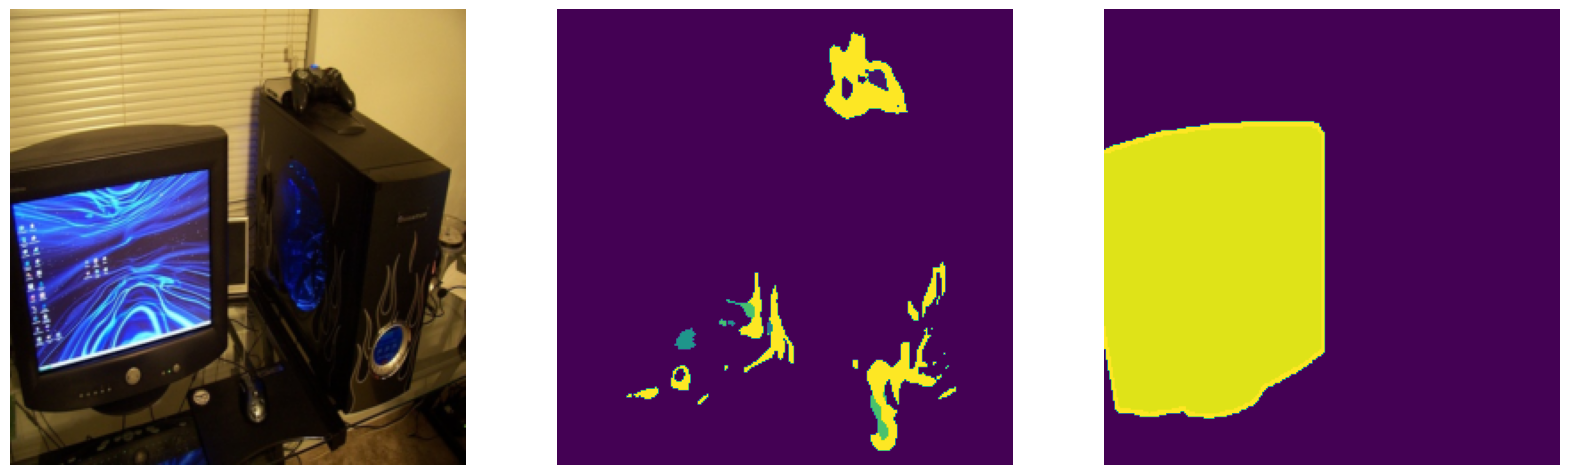

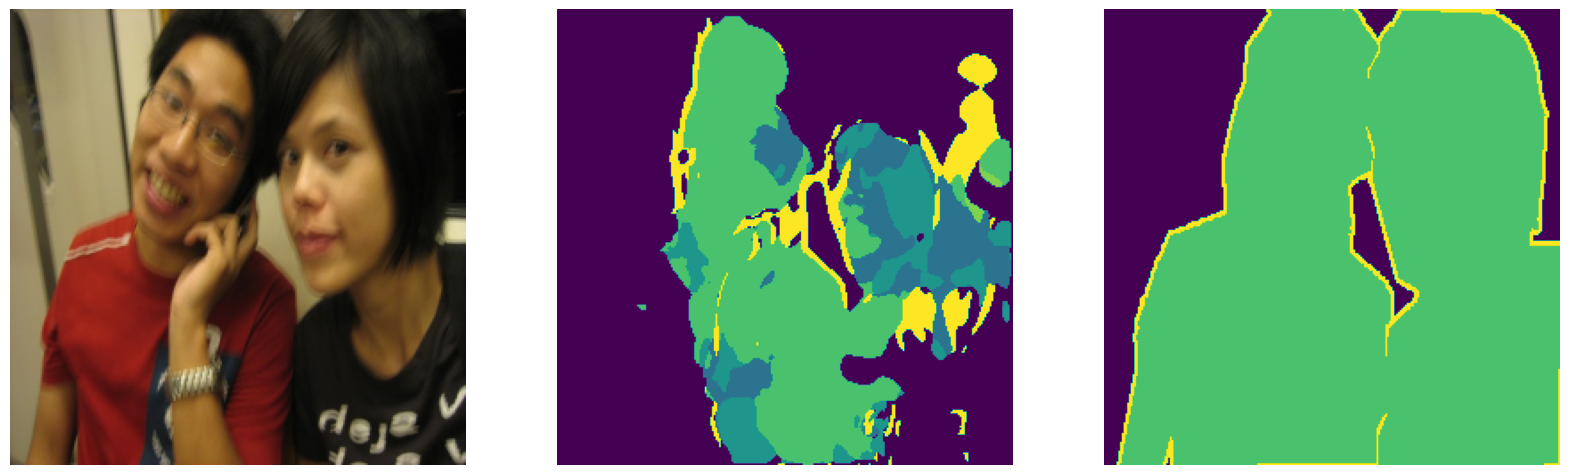

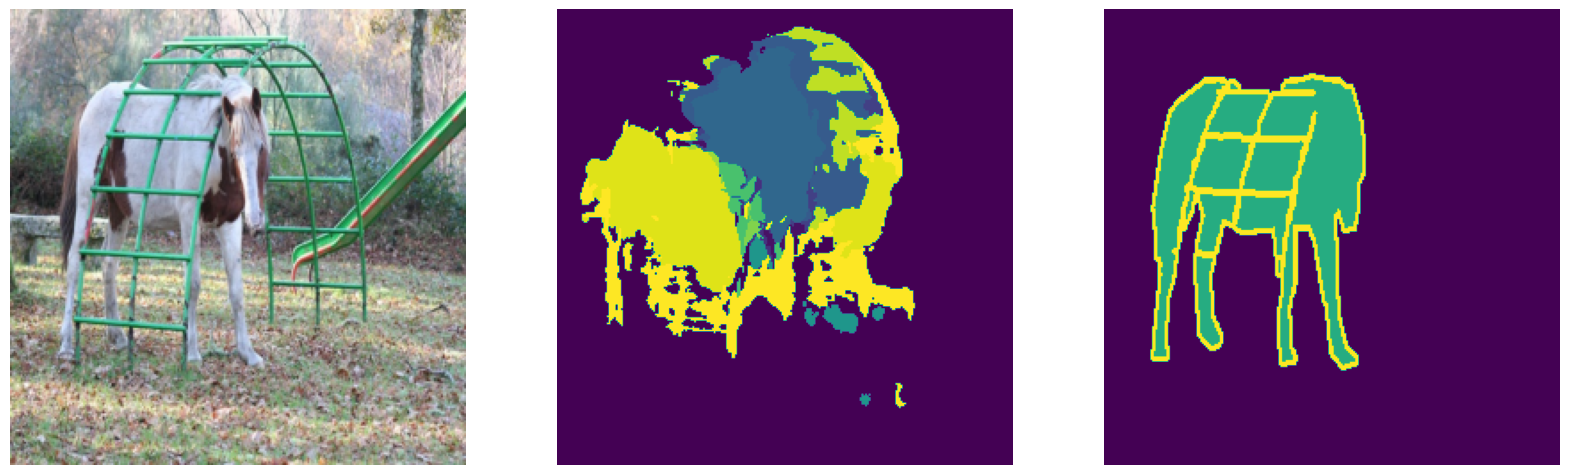

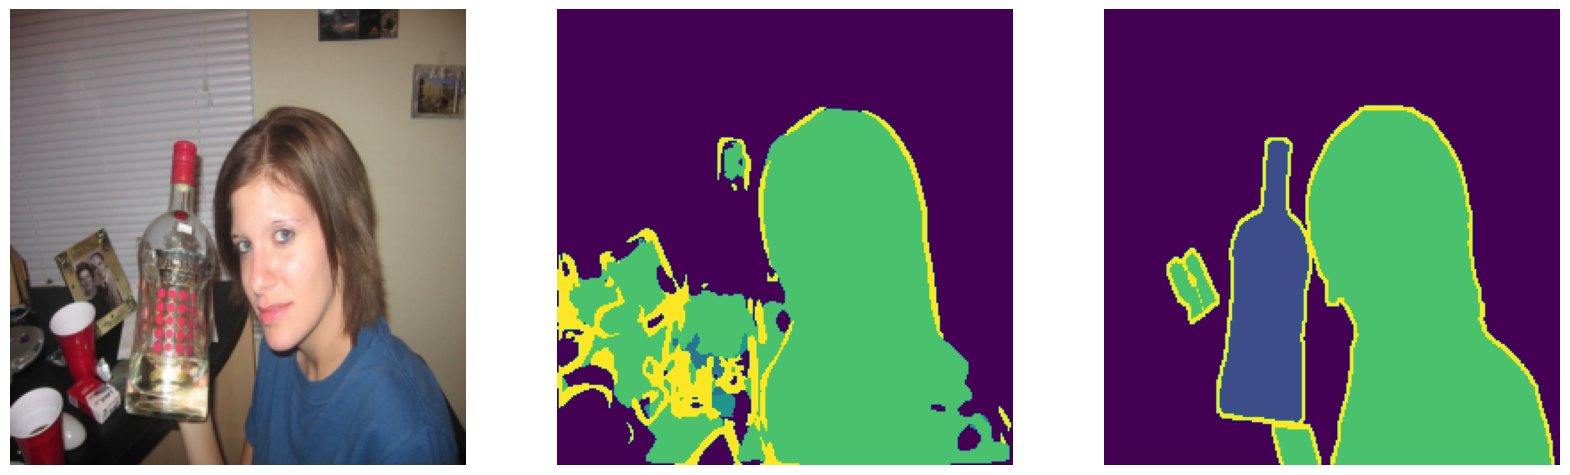

In [13]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(valid_mask, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')